In [1]:
import os
# os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=4'
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,4' 

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
train_ds = tfds.load('mnist', split='train')
test_ds = tfds.load('mnist', split='test')

def data_normalize(ds):
    return ds.map(lambda sample: {
        'image': tf.cast(sample['image'], tf.float32) / 255.,
        'label': sample['label']
    })

train_ds = data_normalize(train_ds).shuffle(buffer_size=10, seed=42).batch(100).prefetch(1).take(1000)
test_ds = data_normalize(test_ds).shuffle(buffer_size=10, seed=42).batch(100).prefetch(1).take(1000)

total_batch = train_ds.cardinality().numpy()
total_tbatch = test_ds.cardinality().numpy()

2024-05-13 21:20:02.471513: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-05-13 21:20:03.215228: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-05-13 21:20:05.262752: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [16]:
import jax
import numpy as np
import jax.numpy as jnp
import optax
from functools import partial



rng = jax.random.PRNGKey(42)
kernel = jax.nn.initializers.xavier_normal()(rng, (3, 3, 1, 16))
fc = jax.nn.initializers.xavier_normal()(rng, (16 * 28 * 28, 10))
kernel = jnp.transpose(kernel, [3, 2, 0, 1])
theta = [kernel, fc]


def forward(x, theta):
    kernel, fc = theta[0], theta[1]
    x = jnp.transpose(x, [0, 3, 1, 2])
    x = jax.lax.conv(x, kernel, window_strides=(1, 1), padding='SAME')
    x = jax.nn.relu(x)
    x = jnp.transpose(x, [0, 2, 3, 1])
    x = x.reshape((x.shape[0], -1))
    x = jnp.dot(x, fc)
    x = jax.nn.softmax(x)
    return x, x

def loss(theta):
    output, state = forward(x, theta)
    l = optax.softmax_cross_entropy_with_integer_labels(jnp.clip(output, 1e-10, 1.), y)
    return l.mean()

@jax.jit
def train(x, y, theta):
    lr = 0.001
    values, grads = jax.value_and_grad(loss)(theta)
    kernel = theta[0]
    fc = theta[1]
    kernel = kernel - lr * grads[0]
    fc = fc - lr * grads[1]
    theta = [kernel, fc]
    return theta

# net.init()
for epoch in range(1000):
    for batch in train_ds.as_numpy_iterator():
        x = batch['image']
        y = batch['label']
        theta = train(x, y, theta)
    print(f"[Epoch {epoch}] loss = ", loss(theta))


[Epoch 0] loss =  2.290639
[Epoch 1] loss =  2.271406
[Epoch 2] loss =  2.2278469
[Epoch 3] loss =  2.1510475
[Epoch 4] loss =  2.0585098
[Epoch 5] loss =  1.9991235
[Epoch 6] loss =  1.9457095
[Epoch 7] loss =  1.8758774
[Epoch 8] loss =  1.8267868
[Epoch 9] loss =  1.7778772
[Epoch 10] loss =  1.7657373
[Epoch 11] loss =  1.7384131
[Epoch 12] loss =  1.7188371
[Epoch 13] loss =  1.7106619
[Epoch 14] loss =  1.706725
[Epoch 15] loss =  1.696376
[Epoch 16] loss =  1.6888374
[Epoch 17] loss =  1.684547
[Epoch 18] loss =  1.6796346
[Epoch 19] loss =  1.6691384
[Epoch 20] loss =  1.6658685
[Epoch 21] loss =  1.6714599
[Epoch 22] loss =  1.6601355
[Epoch 23] loss =  1.6604081
[Epoch 24] loss =  1.6645339
[Epoch 25] loss =  1.66379
[Epoch 26] loss =  1.6508442
[Epoch 27] loss =  1.6574625
[Epoch 28] loss =  1.6633481
[Epoch 29] loss =  1.6505286
[Epoch 30] loss =  1.655322
[Epoch 31] loss =  1.6494021
[Epoch 32] loss =  1.6592267
[Epoch 33] loss =  1.6573942
[Epoch 34] loss =  1.6473702
[Ep

KeyboardInterrupt: 

In [19]:
import jax
import numpy as np
import jax.numpy as jnp
import optax
from functools import partial



rng = jax.random.PRNGKey(42)
kernel = jax.nn.initializers.xavier_normal()(rng, (3, 3, 1, 16))
fc = jax.nn.initializers.xavier_normal()(rng, (16 * 28 * 28, 10))
kernel = jnp.transpose(kernel, [3, 2, 0, 1])
gamma = jnp.ones((1, 16, 1, 1))
beta = jnp.zeros((1, 16, 1, 1))

theta = [kernel, fc, gamma, beta]


def forward(x, theta):
    kernel, fc = theta[0], theta[1]
    gamma, beta = theta[2], theta[3]
    x = jnp.transpose(x, [0, 3, 1, 2])
    x = jax.lax.conv(x, kernel, window_strides=(1, 1), padding='SAME')
    x = jax.nn.relu(x)

    mu = jnp.mean(x, axis=(0, 2, 3), keepdims=True)
    sigma = jnp.std(x, axis=(0, 2, 3), keepdims=True)
    x = (x - mu) / jnp.sqrt(sigma**2 + 1e-6)
    x = gamma * x + beta

    x = jnp.transpose(x, [0, 2, 3, 1])
    x = x.reshape((x.shape[0], -1))
    x = jnp.dot(x, fc)
    x = jax.nn.softmax(x)
    return x, x

def loss(theta):
    output, state = forward(x, theta)
    l = optax.softmax_cross_entropy_with_integer_labels(jnp.clip(output, 1e-10, 1.), y)
    return l.mean()

@jax.jit
def train(x, y, theta):
    lr = 0.001
    values, grads = jax.value_and_grad(loss)(theta)
    kernel = theta[0]
    fc = theta[1]
    gamma = theta[2]
    beta = theta[3]
    
    kernel = kernel - lr * grads[0]
    fc = fc - lr * grads[1]
    gamma = gamma - lr * grads[2]
    beta = beta - lr * grads[3]
    theta = [kernel, fc, gamma, beta]
    return theta

# net.init()
for epoch in range(1000):
    for batch in train_ds.as_numpy_iterator():
        x = batch['image']
        y = batch['label']
        theta = train(x, y, theta)
    print(f"[Epoch {epoch}] loss = ", loss(theta))


[Epoch 0] loss =  1.7775465
[Epoch 1] loss =  1.7409087
[Epoch 2] loss =  1.7279048
[Epoch 3] loss =  1.7022152
[Epoch 4] loss =  1.7008291
[Epoch 5] loss =  1.724504
[Epoch 6] loss =  1.7005078
[Epoch 7] loss =  1.7061203
[Epoch 8] loss =  1.700802
[Epoch 9] loss =  1.6957603
[Epoch 10] loss =  1.6932017
[Epoch 11] loss =  1.7028642
[Epoch 12] loss =  1.6883456
[Epoch 13] loss =  1.7118258
[Epoch 14] loss =  1.6898215
[Epoch 15] loss =  1.6853818
[Epoch 16] loss =  1.6866696
[Epoch 17] loss =  1.6877643
[Epoch 18] loss =  1.6910033
[Epoch 19] loss =  1.6825341
[Epoch 20] loss =  1.6868744
[Epoch 21] loss =  1.6859177
[Epoch 22] loss =  1.6828715
[Epoch 23] loss =  1.6744134
[Epoch 24] loss =  1.6992117
[Epoch 25] loss =  1.6910188
[Epoch 26] loss =  1.6956946
[Epoch 27] loss =  1.6854681
[Epoch 28] loss =  1.6833357
[Epoch 29] loss =  1.6926
[Epoch 30] loss =  1.6984931
[Epoch 31] loss =  1.693403
[Epoch 32] loss =  1.6886631
[Epoch 33] loss =  1.6800343
[Epoch 34] loss =  1.6852155
[

KeyboardInterrupt: 

In [5]:
import jax
import jax.numpy as jnp
import numpy as np
import optax
from jax.sharding import Mesh, PartitionSpec, NamedSharding
from jax.experimental import mesh_utils
from functools import partial

mesh = Mesh(np.array(jax.devices()).reshape((2, 2)), ('x', 'y'))


def net(x, theta):
    kernel = theta[0]
    gamma = theta[1]
    beta = theta[2]
    fc = theta[3]

    x = jnp.transpose(x, [0, 3, 1, 2])
    z = jax.lax.conv(x, kernel, window_strides=(1, 1), padding='SAME')
    z = batchnorm(z, gamma, beta)
    z = jax.nn.relu(z)
    z = jnp.transpose(z, [0, 2, 3, 1])
    z = z.reshape((z.shape[0], -1))
    z = jnp.dot(z, fc)
    return jax.nn.softmax(z)

def batchnorm(z, gamma, beta, momentum=0.9, train=True):
    '''Where is moving mu and var?'''
    mu = jnp.mean(z, axis=(0, 2, 3), keepdims=True)
    sigma = jnp.std(z, axis=(0, 2, 3), keepdims=True)
    moving_mu = momentum * moving_mu + (1 - momentum) * mu
    moving_sigma = momentum * moving_sigma + (1 - momentum) * sigma
    z = (z - mu) / jnp.sqrt(sigma**2 + 1e-6)
    z = gamma * z + beta
    return z

def loss(theta, x, y):
    x = net(x, theta)
    l = optax.softmax_cross_entropy_with_integer_labels(jnp.clip(x, 1e-10, 1.), y)
    return l.mean()

@partial(jax.jit,
            in_shardings=(
                NamedSharding(mesh, PartitionSpec(None, 'y')),
                NamedSharding(mesh, PartitionSpec('x', None)),
                NamedSharding(mesh, PartitionSpec())
            ), static_argnums=())
def train(theta, x, y):
    value, grad = jax.value_and_grad(loss)(theta, x, y)
    (kernel, gamma, beta, fc) = theta
    kernel = kernel - 0.001 * grad[0]
    gamma = gamma - 0.001 * grad[1]
    beta = beta - 0.001 * grad[2]
    fc = fc - 0.001 * grad[3]
    theta = (kernel, gamma, beta, fc)
    return value, theta
    

kernel = jax.nn.initializers.xavier_normal()(jax.random.key(42), (3, 3, 1, 16))
kernel = jnp.transpose(kernel, [3, 2, 0, 1])
fc = jax.nn.initializers.xavier_normal()(jax.random.key(43), (16 * 28 * 28, 10))
gamma = jnp.ones((1, 16, 1, 1))
beta = jnp.zeros((1, 16, 1, 1))

theta = (kernel, gamma, beta, fc)

plt_gamma, plt_beta = [], []
plt_loss = []

for i in range(100):
    for batch in train_ds.as_numpy_iterator():
        x = batch['image']
        y = batch['label']
        value, theta = train(theta, x, y)
    plt_loss.append(value)
    plt_gamma.append(theta[2].mean())
    plt_beta.append(theta[3].mean())
    print(f"{i}-epoch's J = ", value)

    val_acc = []
    for tbatch in test_ds.as_numpy_iterator():
        x = tbatch['image']
        y = tbatch['label']
        pred = net(x, theta)
        acc = jnp.mean(jnp.argmax(pred, axis=1) == y)
        val_acc.append(acc)
    
    val_acc = jnp.array(val_acc)
    print(f"{i}-epoch's Test Accuracy = ", val_acc.mean())


2024-05-13 21:22:14.060224: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


ValueError: One of pjit arguments with pytree key path theta[0] was given the sharding of NamedSharding(mesh={'x': 2, 'y': 2}, spec=PartitionSpec(None, 'y')), which implies that the global size of its dimension 1 should be divisible by 2, but it is equal to 1 (full shape: (16, 1, 3, 3))

Text(0.5, 1.0, 'training loss')

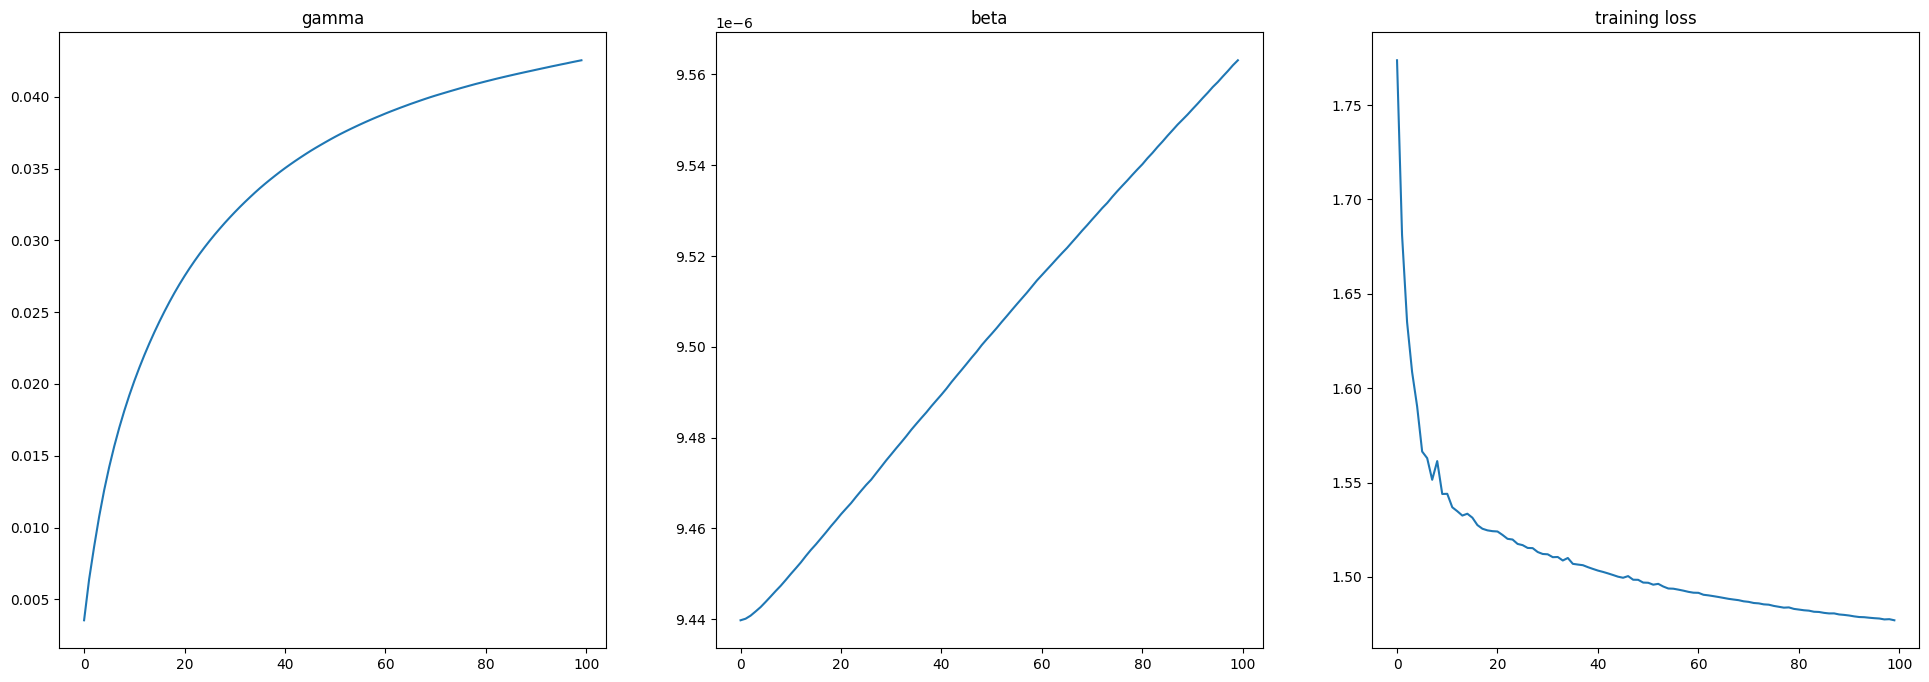

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(24, 8))
ax = ax.flatten()

ax[0].plot(range(len(plt_gamma)), plt_gamma)
ax[1].plot(range(len(plt_beta)), plt_beta)
ax[2].plot(range(len(plt_loss)), plt_loss)

ax[0].set_title('gamma')
ax[1].set_title('beta')
ax[2].set_title('training loss')


Text(0.5, 1.0, 'training loss')

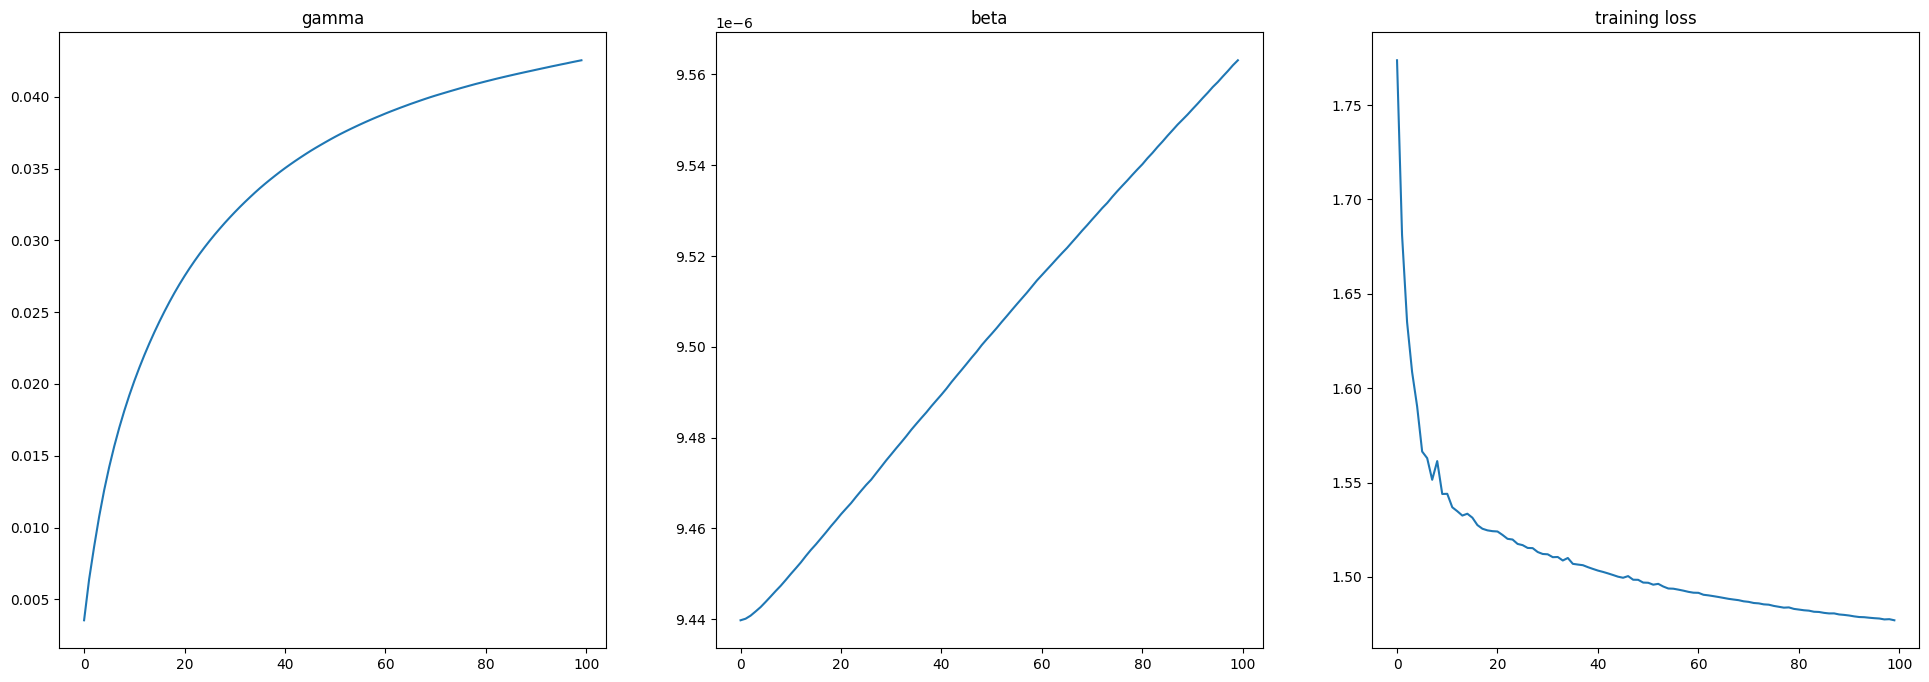

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(24, 8))
ax = ax.flatten()

ax[0].plot(range(len(plt_gamma)), plt_gamma)
ax[1].plot(range(len(plt_beta)), plt_beta)
ax[2].plot(range(len(plt_loss)), plt_loss)

ax[0].set_title('gamma')
ax[1].set_title('beta')
ax[2].set_title('training loss')

# BN complete

In [10]:
print(mesh)

Mesh(device_ids=array([[0, 1],
       [2, 3]]), axis_names=('x', 'y'))


In [15]:
import jax
import jax.numpy as jnp
import numpy as np
import optax
from jax.sharding import Mesh, PartitionSpec, NamedSharding
from jax.experimental import mesh_utils
from functools import partial

mesh = Mesh(np.array(jax.devices()).reshape((2, 2)), ('x', 'y'))


def net(x, theta, stats, train=True):
    kernel = theta[0]
    gamma = theta[1]
    beta = theta[2]
    fc = theta[3]
    moving_mu = stats[0]
    moving_sigma = stats[1]

    x = jnp.transpose(x, [0, 3, 1, 2])
    z = jax.lax.conv(x, kernel, window_strides=(1, 1), padding='SAME')
    z = batchnorm(z, gamma, beta, moving_mu, moving_sigma, train=train)
    z = jax.nn.relu(z)
    z = jnp.transpose(z, [0, 2, 3, 1])
    z = z.reshape((z.shape[0], -1))
    z = jnp.dot(z, fc)
    return jax.nn.softmax(z)

def batchnorm(z, gamma, beta, moving_mu, moving_sigma, momentum=0.9, train=True):
    '''Where is moving mu and var?'''
    
    if train == True:
        mu = jnp.mean(z, axis=(0, 2, 3), keepdims=True)
        sigma = jnp.std(z, axis=(0, 2, 3), keepdims=True)
        moving_mu = momentum * moving_mu + (1 - momentum) * mu
        moving_sigma = momentum * moving_sigma + (1 - momentum) * sigma
        z = (z - mu) / jnp.sqrt(sigma**2 + 1e-6)
    else:
        z = (z - moving_mu) / jnp.sqrt(moving_sigma**2 + 1e-6)
    z = gamma * z + beta
    return z

def loss(theta, stats, x, y):
    x = net(x, theta, stats)
    l = optax.softmax_cross_entropy_with_integer_labels(jnp.clip(x, 1e-10, 1.), y)
    return l.mean()

# @partial(jax.jit,
#             in_shardings=(
#                 NamedSharding(mesh, PartitionSpec('x')),
#                 NamedSharding(mesh, PartitionSpec('x')),
#                 NamedSharding(mesh, PartitionSpec()),
#                 NamedSharding(mesh, PartitionSpec())
#             ), static_argnums=())
@jax.jit
def train(theta, stats, x, y):
    value, grad = jax.value_and_grad(loss)(theta, stats, x, y)
    (kernel, gamma, beta, fc) = theta
    kernel = kernel - 0.001 * grad[0]
    gamma = gamma - 0.001 * grad[1]
    beta = beta - 0.001 * grad[2]
    fc = fc - 0.001 * grad[3]

    theta = (kernel, gamma, beta, fc)
    stats = (moving_mu, moving_sigma)
    return value, theta, stats
    

kernel = jax.nn.initializers.xavier_normal()(jax.random.key(42), (3, 3, 1, 16))
kernel = jnp.transpose(kernel, [3, 2, 0, 1])
fc = jax.nn.initializers.xavier_normal()(jax.random.key(43), (16 * 28 * 28, 10))
gamma = jnp.ones((1, 16, 1, 1))
beta = jnp.zeros((1, 16, 1, 1))
theta = (kernel, gamma, beta, fc)

moving_mu = jnp.zeros((1, 16, 1, 1), dtype=jnp.float32)
moving_sigma = jnp.zeros((1, 16, 1, 1), dtype=jnp.float32)
stats = (moving_mu, moving_sigma)

plt_gamma, plt_beta = [], []
plt_loss = []

for i in range(100):
    for batch in train_ds.as_numpy_iterator():
        x = batch['image']
        y = batch['label']
        value, theta, stats = train(theta, stats, x, y)
    plt_loss.append(value)
    plt_gamma.append(theta[2].mean())
    plt_beta.append(theta[3].mean())
    print(f"{i}-epoch's J = ", value)

    val_acc = []
    for tbatch in test_ds.as_numpy_iterator():
        x = tbatch['image']
        y = tbatch['label']
        pred = net(x, theta, stats, train=False)
        acc = jnp.mean(jnp.argmax(pred, axis=1) == y)
        val_acc.append(acc)
    
    val_acc = jnp.array(val_acc)
    print(f"{i}-epoch's Test Accuracy = ", val_acc.mean())


0-epoch's J =  1.7565844
0-epoch's Test Accuracy =  0.76089996
1-epoch's J =  1.6753863
1-epoch's Test Accuracy =  0.8067
2-epoch's J =  1.6439724
2-epoch's Test Accuracy =  0.8302
3-epoch's J =  1.6091344


KeyboardInterrupt: 